In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv(r"C:\Users\sinha\Desktop\Cohort\Capestone\Survey Reprised 2.0.csv")

In [4]:
df1 = df.drop(['Timestamp', 'Country'], axis=1)

df1.drop(df1[df1['Age'] < 21].index, inplace=True)
df1.drop(df1[df1['Age'] > 45].index, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1173 entries, 0 to 1230
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 1173 non-null   int64 
 1   Age                        1173 non-null   int64 
 2   self_employed              1173 non-null   object
 3   family_history             1173 non-null   object
 4   treatment                  1173 non-null   object
 5   work_interfere             1173 non-null   object
 6   no_employees               1173 non-null   int64 
 7   remote_work                1173 non-null   object
 8   tech_company               1173 non-null   object
 9   benefits                   1173 non-null   object
 10  care_options               1173 non-null   object
 11  wellness_program           1173 non-null   object
 12  seek_help                  1173 non-null   object
 13  anonymity                  1173 non-null   object
 14  leave        

# **A. Classification**
* **Objective**: Predict whether a person is likely to seek mental health treatment (treatment column: yes/no)
* **Input Features**: Workplace support, past diagnosis, family history, leave policies, etc.
* **Algorithms to Try**: Logistic Regression, Random Forest, XGBoost and SVM
* **Evaluation**: Accuracy, ROC-AUC, Confusion Matrix, F1 Score

In [5]:
X = df1[['self_employed','Age', 'family_history', 'work_interfere', 'remote_work', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'leave', 'obs_consequence', 'supervisor', 'mental_health_interview', 'Gender_cleaned']]
y = df1['treatment']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


* **LogisticRegression Model**

In [8]:
categorical = X.columns.tolist()
cat_trans = OneHotEncoder(handle_unknown='ignore')

preproc = ColumnTransformer(
    transformers=[('cat', cat_trans, categorical)]
)

pipeline = Pipeline(steps=[
    ('preproc', preproc),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [9]:
param = {
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear']
}

In [10]:
grid_search_lr = GridSearchCV(pipeline, param, cv=3, scoring='accuracy', n_jobs=1)
grid_search_lr.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'classifier__C': [0.1, 1], 'classifier__penalty': ['l2'], 'classifier__solver': ['liblinear']}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [11]:
y_pred_lr = grid_search_lr.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))



Classification Report:
              precision    recall  f1-score   support

          No       0.82      0.76      0.79       112
         Yes       0.79      0.85      0.82       123

    accuracy                           0.80       235
   macro avg       0.81      0.80      0.80       235
weighted avg       0.81      0.80      0.80       235



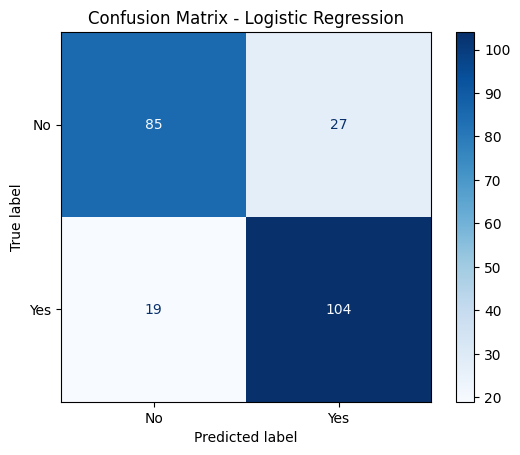

In [12]:
cm = confusion_matrix(y_test, y_pred_lr, labels=grid_search_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_lr.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

* **RandomForest Classifier**

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

          No       0.83      0.76      0.79       112
         Yes       0.80      0.86      0.83       123

    accuracy                           0.81       235
   macro avg       0.82      0.81      0.81       235
weighted avg       0.81      0.81      0.81       235

F1 Macro Average (FMA): 0.8113
ROC-AUC Score: 0.8924


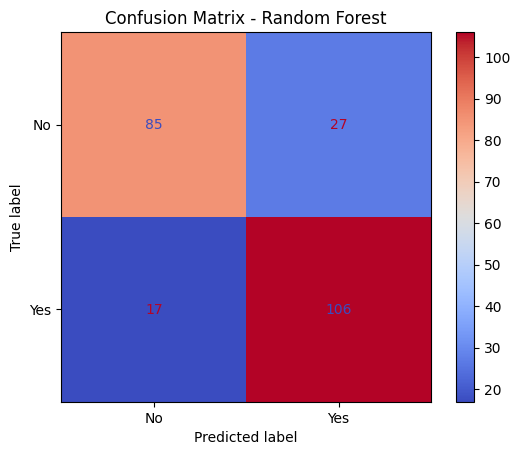

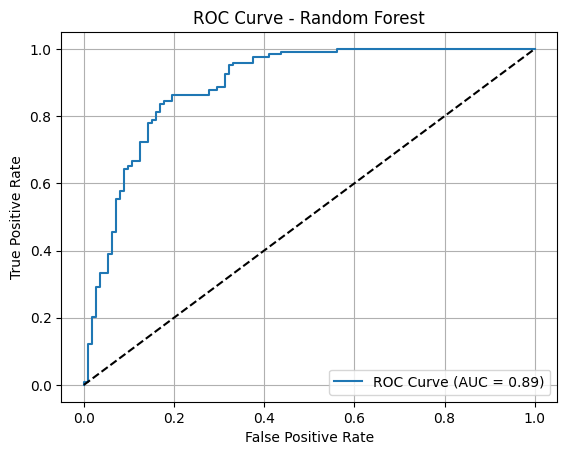

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
categorical_rf = X.columns.tolist()
cat_tans_rf = OneHotEncoder(handle_unknown='ignore')
preproc_rf = ColumnTransformer(transformers=[('cat', cat_tans_rf, categorical_rf)])

# Random Forest pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preproc_rf),
    ('classifier', RandomForestClassifier(random_state=42))])

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}
# GridSearchCV
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='accuracy', n_jobs=1)
grid_search.fit(X_train, y_train)

# Predictions
y_pred_rf = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1] 
print("Best Parameters:", grid_search.best_params_)
report = classification_report(y_test, y_pred_rf, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# F1 Macro Average
fma = report['macro avg']['f1-score']
print(f"F1 Macro Average (FMA): {fma:.4f}")

# ROC-AUC Score
y_test_binary = y_test.map({'No': 0, 'Yes': 1})
roc_auc = roc_auc_score(y_test_binary, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap='coolwarm')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

* **SVM Classifier**

In [14]:
from sklearn.svm import SVC

X_svm = df1[['self_employed', 'Age', 'family_history', 'work_interfere', 'remote_work', 'benefits',
        'care_options', 'wellness_program', 'seek_help', 'leave', 'obs_consequence',
        'supervisor', 'mental_health_interview', 'Gender_cleaned']]
y_svm = df1['treatment']

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)


In [15]:
# Preprocessing
cat_feat_svm = X_svm.columns.tolist()

preproc_svm = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feat_svm)
    ]
)

In [16]:
# SVM classifier pipeline
from sklearn.preprocessing import StandardScaler
pipeline_svm = Pipeline([
    ('preprocessor', preproc_svm),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', SVC(probability=True))
])

In [17]:
param_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 0.01, 0.001],
    'classifier__kernel': ['rbf', 'linear']
}

In [18]:
# GridSearchCV for hyperparameter tuning
grid_search_svm = GridSearchCV(pipeline_svm, param_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_svm, y_train_svm)

,estimator,Pipeline(step...ility=True))])
,param_grid,"{'classifier__C': [0.1, 1, ...], 'classifier__gamma': ['scale', 0.01, ...], 'classifier__kernel': ['rbf', 'linear']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [19]:
# Evaluation
y_pred_svm = grid_search_svm.predict(X_test_svm)
print("Best Parameters:", grid_search_svm.best_params_)
print("\nClassification Report:\n", classification_report(y_test_svm, y_pred_svm))

Best Parameters: {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

          No       0.92      0.74      0.82       112
         Yes       0.80      0.94      0.87       123

    accuracy                           0.85       235
   macro avg       0.86      0.84      0.84       235
weighted avg       0.86      0.85      0.84       235



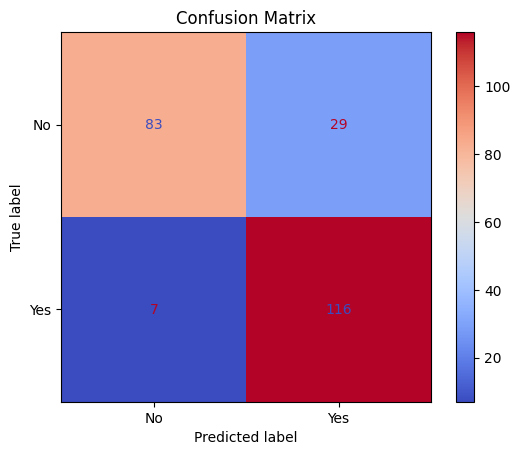

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predict labels
y_pred_svm = grid_search_svm.predict(X_test_svm)

# Confusion Matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap='coolwarm')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


# **B. Regression**
* **Objective**: Predict the respondent's age
* **Use Case**: Identifying age-based risk factors or bias in workplace culture
* **Input Features**: Workplace type, gender, openness about mental health, remote work, etc.
* **Evaluation**: RMSE, MAE, R² score

In [21]:
osim = pd.read_csv(r"C:\Users\sinha\Desktop\Cohort\Capestone\Survey_reprised.csv")

* Encoding

In [22]:
osim1 = osim.drop(['Timestamp', 'Country'], axis=1)

osim1.drop(osim1[osim1['Age'] < 21].index, inplace=True)
osim1.drop(osim1[osim1['Age'] > 45].index, inplace=True)
osim1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1173 entries, 0 to 1246
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1173 non-null   int64 
 1   self_employed              1173 non-null   object
 2   family_history             1173 non-null   object
 3   treatment                  1173 non-null   object
 4   work_interfere             1173 non-null   object
 5   no_employees               1173 non-null   int64 
 6   remote_work                1173 non-null   object
 7   tech_company               1173 non-null   object
 8   benefits                   1173 non-null   object
 9   care_options               1173 non-null   object
 10  wellness_program           1173 non-null   object
 11  seek_help                  1173 non-null   object
 12  anonymity                  1173 non-null   object
 13  leave                      1173 non-null   object
 14  mental_health

In [23]:
import pandas as pd
import numpy as np

# Replace ambiguous text with NaN
ambiguous_values = ["Don't know", "Maybe", "Unknown"]
osim1.replace(ambiguous_values, np.nan, inplace=True)

# Simplify Gender
osim1['Gender_cleaned'] = osim1['Gender_cleaned'].str.lower()
osim1['Gender_cleaned'] = osim1['Gender_cleaned'].apply(
    lambda x: 'male' if 'male' in x else ('female' if 'female' in x else 'other')
)

# Bin no_employees
osim1['no_employees_bin'] = pd.cut(osim1['no_employees'],
                                bins=[0, 10, 50, 250, 1000, np.inf],
                                labels=['Micro', 'Small', 'Medium', 'Large', 'Enterprise'])

# Binary columns mapping
binary_cols = [
    'self_employed', 'family_history', 'treatment', 'remote_work', 'tech_company',
    'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity',
    'mental_health_consequence', 'phys_health_consequence', 'coworkers',
    'supervisor', 'mental_health_interview', 'phys_health_interview',
    'mental_vs_physical', 'obs_consequence'
]

# Map Yes/No to 1/0
binary_map = {'Yes': 1, 'No': 0}
for col in binary_cols:
    osim1[col] = osim1[col].map(binary_map)

# Ordinal columns
ordinal_mappings = {
    'work_interfere': {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3},
    'leave': {
        'Very difficult': 0, 'Somewhat difficult': 1, 'Somewhat easy': 2, 'Very easy': 3
    }
}
for col, mapping in ordinal_mappings.items():
    osim1[col] = osim1[col].map(mapping)

# One-hot encode categorical variables
osim1_encoded = pd.get_dummies(osim1, columns=[
    'Gender_cleaned', 'no_employees_bin'
], drop_first=True)

# Drop rows with missing Age
osim1_encoded.dropna(subset=['Age'], inplace=True)

# Fill remaining NaNs with -1
osim1_encoded.fillna(-1, inplace=True)


In [24]:
osim1_encoded

,Age,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Gender_cleaned_other,no_employees_bin_Small,no_employees_bin_Medium,no_employees_bin_Large,no_employees_bin_Enterprise
0,37,-1.0,0,1,3.0,15,0,1,1.0,-1.0,...,1.0,0.0,-1.0,1.0,0,False,True,False,False,False
1,44,-1.0,0,0,1.0,1200,0,0,-1.0,0.0,...,0.0,0.0,0.0,-1.0,0,False,False,False,False,True
2,32,-1.0,0,0,1.0,15,0,1,0.0,0.0,...,1.0,1.0,1.0,0.0,0,False,True,False,False,False
3,31,-1.0,1,1,3.0,63,0,1,0.0,1.0,...,0.0,-1.0,-1.0,0.0,1,False,False,True,False,False
4,31,-1.0,0,0,0.0,300,1,1,1.0,0.0,...,1.0,1.0,1.0,-1.0,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,36,0.0,1,0,1.0,1200,0,0,-1.0,0.0,...,-1.0,0.0,0.0,-1.0,0,False,False,False,False,True
1242,26,0.0,0,1,-1.0,63,0,1,0.0,0.0,...,-1.0,0.0,0.0,-1.0,0,False,False,True,False,False
1243,32,0.0,1,1,3.0,63,1,1,1.0,1.0,...,1.0,0.0,0.0,1.0,0,False,False,True,False,False
1244,34,0.0,1,1,2.0,1200,0,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0,False,False,False,False,True


* **RandomForest**

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

osim_X = osim1_encoded.drop(columns=['Age'])
osim_y = osim1_encoded['Age']

# Train-test split
X_train_rf, X_test_rf, t_train_rf, osim_y_test = train_test_split(osim_X, osim_y, test_size=0.2, random_state=80)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rf)
X_test_scaled = scaler.transform(X_test_rf)

# Define and train the Random Forest Regressor (manuallosim_y tuned)
model_rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42
)
model_rf.fit(X_train_scaled, t_train_rf)

# Make predictions
osim_y_pred = model_rf.predict(X_test_scaled)

# Evaluate performance
mae = mean_absolute_error(osim_y_test, osim_y_pred)
r2 = r2_score(osim_y_test, osim_y_pred)

# Output evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")


Mean Absolute Error (MAE): 4.45
R^2 Score: 0.01


* **ElasticNet**

Mean Squared Error (MSE): 38.09
Mean Absolute Error (MAE): 4.85
R² Score: 0.100


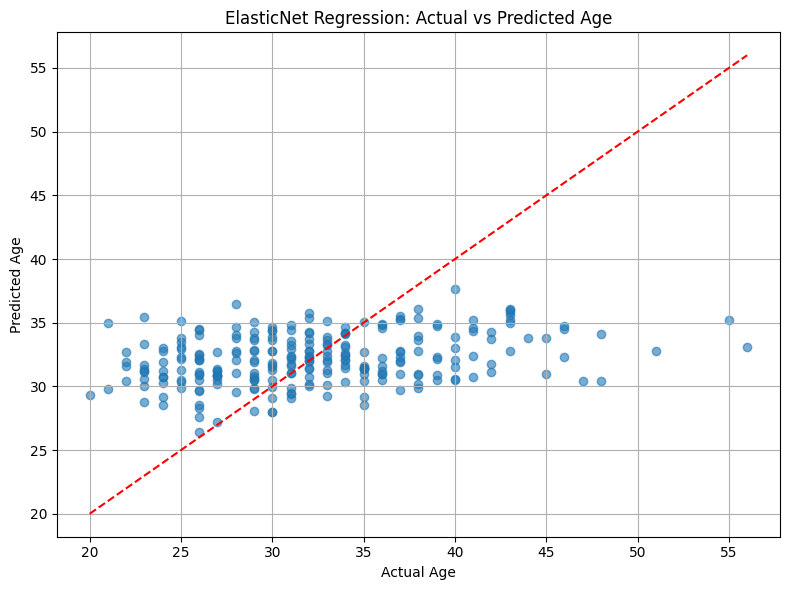

In [26]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
file_path = "Survey Reprised 2.0.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Drop irrelevant or non-predictive columns
df = df.drop(columns=['Unnamed: 0', 'Timestamp'])

# Define features and target
target = 'Age'
X = df.drop(columns=[target])
y = df[target]

# Identify column types
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include='number').columns.tolist()

# Simplify categorical features: group rare categories
X_simplified = X.copy()
for col in categorical_features:
    top_categories = X_simplified[col].value_counts().nlargest(10).index
    X_simplified[col] = X_simplified[col].apply(lambda x: x if x in top_categories else 'Other')

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
])

# Full pipeline with ElasticNet model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_simplified, y, test_size=0.2, random_state=80)

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")

# Visualization: Actual vs Predicted Age
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('ElasticNet Regression: Actual vs Predicted Age')
plt.grid(True)
plt.tight_layout()
plt.show()


* **XGBoost**

In [37]:
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r"C:\Users\sinha\Desktop\Cohort\Capestone\Survey Reprised 2.0.csv")

df = df[(df['Age'] >= 21) & (df['Age'] <= 45)]
df.drop(columns=['Unnamed: 0', 'Timestamp'], inplace=True)

#Encoding
label_encoders = {}
for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
X_all = df.drop(columns=['Age'])
y_all = df['Age']
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)


# # === Use XGBoost to find top 16 features ===
# xgb_temp = XGBRegressor(n_estimators=100, random_state=42)
# xgb_temp.fit(X_all_scaled, y_all)

# importances = pd.Series(xgb_temp.feature_importances_, index=X_all.columns)
# top_16_features = importances.sort_values(ascending=False).head(16).index.tolist()


X = df[[
    'no_employees',
    'leave',
    'care_options',
    'benefits',
    'coworkers',
    'supervisor',
    'mental_health_interview',
    'work_interfere',
    'remote_work',
    'mental_vs_physical',
    'phys_health_interview',
    'obs_consequence',
    'anonymity',
    'wellness_program',
    'seek_help',
    'family_history'
]
]
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

#Hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== MODEL EVALUATION ===")
print("Best Parameters:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

=== MODEL EVALUATION ===
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MAE: 4.97
MSE: 36.32
RMSE: 6.03
R²: 0.039
